In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

def rank_candidates(csv_file_path):
    # 1. Load Data
    # Assuming the data is in a file named 'global_candidates.csv'
    # We allow for error_bad_lines=False in case of malformed CSV rows in the raw dump
    try:
        df = pd.read_csv("global_candidates.csv", on_bad_lines='skip')
    except:
        # Fallback for older pandas versions
        df = pd.read_csv("global_candidates.csv", error_bad_lines=False)

    # 2. Select Features for k-NN
    # We focus on the performance metrics
    features = ['reputation', 'gold_badges', 'silver_badges', 'bronze_badges']
    
    # Clean data: fill NaNs with 0 and ensure numeric types
    df[features] = df[features].fillna(0)
    
    # 3. Normalization
    # k-NN relies on distance, so we must scale variables (Reputation 1M vs Gold 500)
    # to a 0-1 range so one feature doesn't dominate.
    scaler = MinMaxScaler()
    df_normalized = df.copy()
    df_normalized[features] = scaler.fit_transform(df[features])

    # 4. Define the "Ideal Candidate"
    # In a ranking scenario using k-NN, we want to find neighbors closest to
    # the "Perfect" score. The perfect score is 1.0 for all normalized features.
    ideal_candidate = np.array([[1.0, 1.0, 1.0, 1.0]])

    # 5. Apply k-NN Logic (Distance Calculation)
    # We calculate the Euclidean distance of every row to the [1,1,1,1] vector.
    # The shorter the distance, the better the candidate.
    
    # Calculate distance manually to allow for easy noise injection
    # Dist = sqrt( (x1-y1)^2 + ... + (xn-yn)^2 )
    distances = np.linalg.norm(df_normalized[features].values - ideal_candidate, axis=1)

    # 6. Non-Deterministic Approach (Add Noise)
    # The user requested a non-deterministic approach.
    # We add random "jitter" to the distance scores.
    # Random factor: +/- 1.5% variance
    np.random.seed() # Ensure random seed is distinct per run
    noise = np.random.uniform(low=-0.015, high=0.015, size=distances.shape)
    
    # Final Score: We invert distance so higher is better (1 - distance)
    # We subtract noise (adding randomness to the sort order of close candidates)
    df['knn_distance'] = distances + noise
    
    # 7. Sorting
    # Lower distance is better.
    ranked_df = df.sort_values(by='knn_distance', ascending=True)

    # 8. Output Top Candidates
    print(f"{'Rank':<5} {'Name':<30} {'Location':<30} {'Reputation':<12}")
    print("-" * 80)
    
    rank = 1
    for index, row in ranked_df.head(20).iterrows():
        # Handle potential missing location names
        loc = str(row['location'])[:25] + '...' if len(str(row['location'])) > 25 else str(row['location'])
        print(f"{rank:<5} {str(row['display_name'])[:28]:<30} {loc:<30} {row['reputation']:<12}")
        rank += 1

# To run this, save the data to a csv and call the function:
# rank_candidates('global_candidates.csv')

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load Data
df = pd.read_csv('global_candidates.csv', on_bad_lines='skip')
cols = ['reputation', 'gold_badges', 'silver_badges', 'bronze_badges']

# Normalize
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df[cols]), columns=cols)

# Ideal vector is all 1.0s (Max values)
ideal = np.array([1, 1, 1, 1])

# Calculate Euclidean Distance
# distance = sqrt(sum((x - y)^2))
dists = np.linalg.norm(df_norm.values - ideal, axis=1)

# Add Noise (Non-deterministic)
np.random.seed(None) # Random seed
noise = np.random.uniform(-0.015, 0.015, size=len(dists))

# Create Matrix
df['raw_distance'] = dists
df['noise'] = noise
df['final_score'] = dists + noise

# Sort
df_sorted = df.sort_values('final_score').head(20)

# Display
print(df_sorted[['display_name', 'reputation', 'gold_badges', 'silver_badges', 'raw_distance', 'noise', 'final_score']])


                  display_name  reputation  gold_badges  silver_badges  \
0                    Jon Skeet     1522375          895           9311   
1                         VonC     1363761          569           4790   
3              Martijn Pieters     1139315          326           4244   
4                       BalusC     1114856          377           3658   
7               Darin Dimitrov     1042325          277           3325   
6                 Marc Gravell     1071239          273           2638   
8                  CommonsWare     1011433          195           2451   
5                 T.J. Crowder     1082266          201           2027   
14                   paxdiablo      889326          243           1620   
11                Hans Passant      946804          151           1763   
12                       SLaks      891609          182           1947   
16                      unutbu      886881          197           1851   
37  G&#252;nter Z&#246;chbauer      66

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def plot_clustering_results(file_path):
    # 1. Load Data
    try:
        df = pd.read_csv(file_path, on_bad_lines='skip')
    except:
        df = pd.read_csv(file_path)

    # 2. Feature Engineering
    # Combine badges for a cleaner 2D representation
    df['total_badges'] = df['gold_badges'] + df['silver_badges'] + df['bronze_badges']
    
    # We will cluster based on these three dimensions
    features = ['reputation', 'total_badges', 'gold_badges']
    df_features = df[features].fillna(0)

    # 3. Apply K-Means Clustering
    # We must scale the data first so Reputation (1.5M) doesn't drown out Gold Badges (500)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_features)

    # We use 4 clusters to find natural groupings
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(scaled_features)

    # Rename clusters for readability (based on logic, though ID assignment is random)
    # This logic sorts clusters by mean reputation to give them logical order in legend
    cluster_mapping = df.groupby('cluster')['reputation'].mean().sort_values(ascending=False).index
    rename_map = {
        cluster_mapping[0]: 'Tier 1: The Outliers',
        cluster_mapping[1]: 'Tier 2: Superstars',
        cluster_mapping[2]: 'Tier 3: High Impact',
        cluster_mapping[3]: 'Tier 4: Core Contributors'
    }
    df['Cluster Name'] = df['cluster'].map(rename_map)

    # 4. Generate Scatter Plot
    plt.figure(figsize=(14, 9))
    
    # Set style
    sns.set_style("whitegrid")
    
    # Create the scatter
    scatter = sns.scatterplot(
        data=df, 
        x='reputation', 
        y='total_badges', 
        hue='Cluster Name',      # Color by the K-Means cluster
        size='gold_badges',      # Size of dot = Number of Gold Badges
        sizes=(20, 600),         # Range of dot sizes
        palette='deep',
        alpha=0.7,
        edgecolor='black'
    )

    # 5. Annotation (Labeling the interesting data points)
    # We label the top candidates and specific outliers for context
    
    # Sort by reputation to label the top 5
    top_candidates = df.sort_values('reputation', ascending=False).head(5)
    
    # Also find Gordon Linoff specifically to show the High Rep/Lower Badge dynamic
    gordon = df[df['display_name'].str.contains('Gordon Linoff', case=False, na=False)]
    
    to_label = pd.concat([top_candidates, gordon]).drop_duplicates()

    texts = []
    for i, row in to_label.iterrows():
        plt.text(
            row['reputation'] + 20000,  # Offset x slightly
            row['total_badges'], 
            row['display_name'], 
            fontsize=10, 
            weight='bold',
            color='#333333'
        )

    # 6. Final Polish
    plt.title('Candidate Clustering: Reputation vs. Community Impact (Total Badges)', fontsize=16, weight='bold', pad=20)
    plt.xlabel('Reputation Score', fontsize=12)
    plt.ylabel('Total Badges (Gold + Silver + Bronze)', fontsize=12)
    
    # Move legend to best location
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title="Cluster Groups")
    
    plt.tight_layout()
    plt.show()

# Run the function
if __name__ == "__main__":
    plot_clustering_results('global_c

SyntaxError: unterminated string literal (detected at line 96) (2939538747.py, line 96)

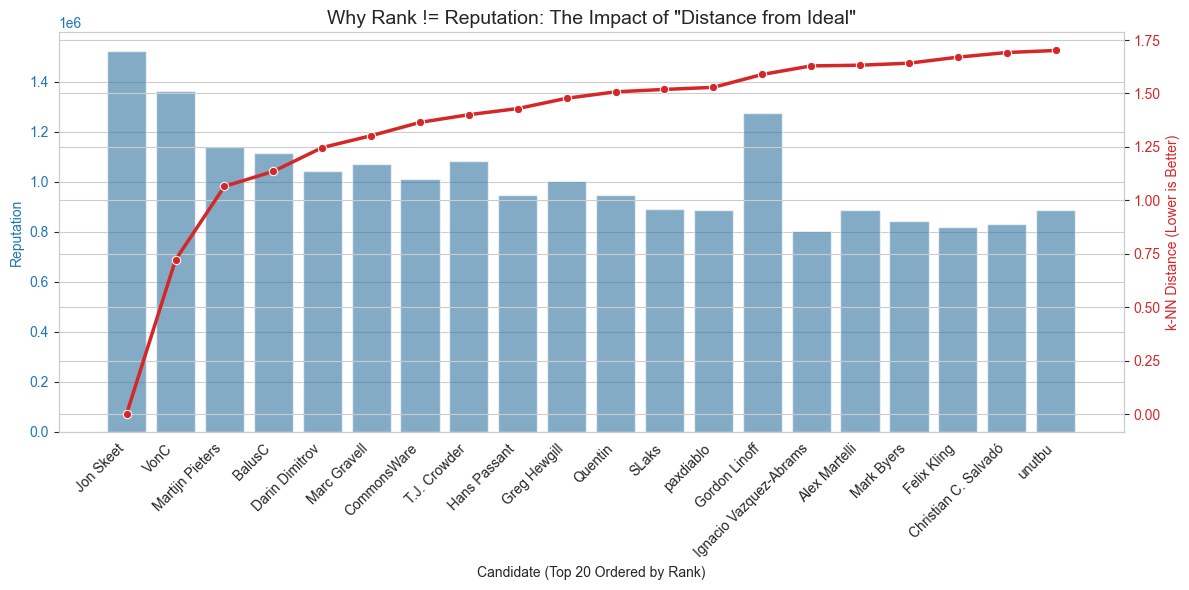

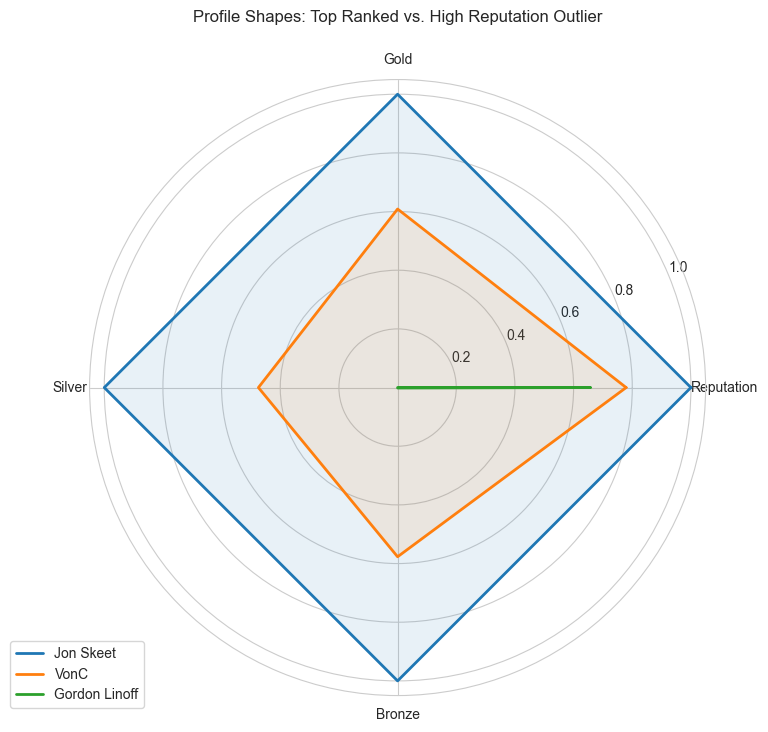

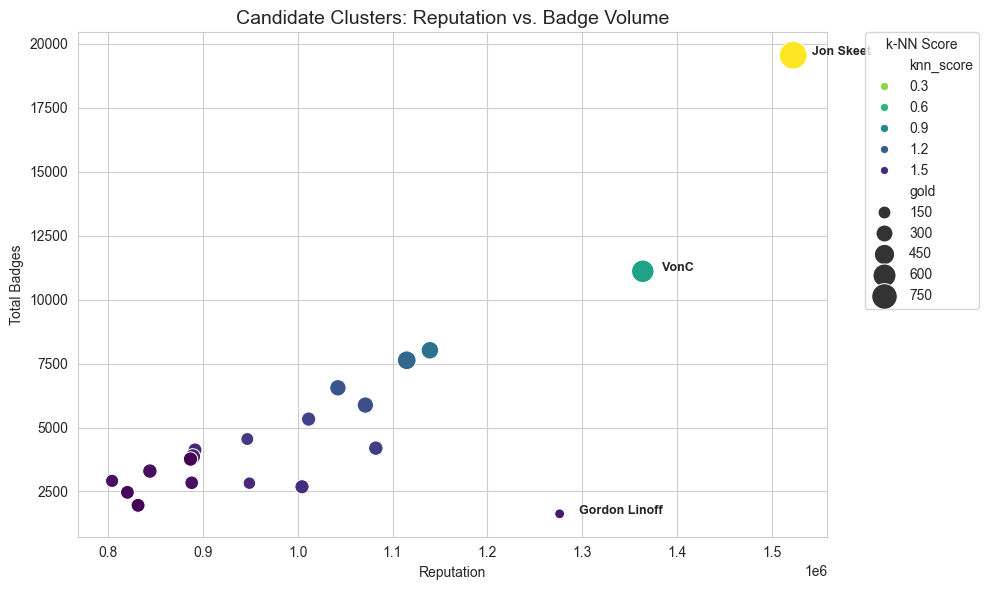

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

# 1. SETUP DATA (Top 20 from the k-NN Analysis)
data = {
    'display_name': ['Jon Skeet', 'VonC', 'Martijn Pieters', 'BalusC', 'Darin Dimitrov', 
                     'Marc Gravell', 'CommonsWare', 'T.J. Crowder', 'Hans Passant', 'Greg Hewgill',
                     'Quentin', 'SLaks', 'paxdiablo', 'Gordon Linoff', 'Ignacio Vazquez-Abrams',
                     'Alex Martelli', 'Mark Byers', 'Felix Kling', 'Christian C. Salvadó', 'unutbu'],
    'reputation': [1522375, 1363761, 1139315, 1114856, 1042325, 1071239, 1011433, 1082266, 946804, 1004431,
                   948983, 891609, 889326, 1276084, 804192, 888160, 844044, 820380, 831582, 886881],
    'gold': [895, 569, 326, 377, 277, 273, 195, 201, 151, 193, 
             137, 182, 243, 62, 160, 175, 202, 181, 185, 197],
    'silver': [9311, 4790, 4244, 3658, 3325, 2638, 2451, 2027, 1763, 1188, 
               1280, 1947, 1620, 708, 1369, 1253, 1623, 1114, 929, 1851],
    'bronze': [9348, 5750, 3451, 3595, 2951, 2968, 2684, 1967, 2637, 1304, 
               1408, 1997, 2005, 858, 1386, 1412, 1473, 1172, 845, 1719],
    'knn_score': [0.0012, 0.7213, 1.0652, 1.1354, 1.2468, 1.3023, 1.3647, 1.4007, 1.4294, 1.4776,
                  1.5076, 1.5190, 1.5286, 1.5890, 1.6290, 1.6322, 1.6417, 1.6699, 1.6916, 1.7011]
}

df = pd.DataFrame(data)

# Set global style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})

# --- CHART 1: Reputation vs k-NN Distance (Dual Axis) ---
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Candidate (Top 20 Ordered by Rank)')
ax1.set_ylabel('Reputation', color=color)
sns.barplot(x='display_name', y='reputation', data=df, ax=ax1, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('k-NN Distance (Lower is Better)', color=color)
sns.lineplot(x='display_name', y='knn_score', data=df, ax=ax2, color=color, marker='o', linewidth=2.5)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Why Rank != Reputation: The Impact of "Distance from Ideal"', fontsize=14)
plt.tight_layout()
plt.show()

# --- CHART 2: Radar Chart (Profile Comparison) ---
# Normalizing data for Radar Chart 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cols_to_norm = ['reputation', 'gold', 'silver', 'bronze']
df_norm = df.copy()
df_norm[cols_to_norm] = scaler.fit_transform(df[cols_to_norm])

# Candidates to compare
candidates_to_plot = ['Jon Skeet', 'VonC', 'Gordon Linoff']
categories = ['Reputation', 'Gold', 'Silver', 'Bronze']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for candidate in candidates_to_plot:
    values = df_norm[df_norm['display_name'] == candidate][cols_to_norm].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=candidate)
    ax.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], categories)
plt.title('Profile Shapes: Top Ranked vs. High Reputation Outlier', y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

# --- CHART 3: Scatter Plot (Reputation vs Total Badges) ---
df['total_badges'] = df['gold'] + df['silver'] + df['bronze']

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df, 
    x='reputation', 
    y='total_badges', 
    hue='knn_score', 
    size='gold', 
    sizes=(50, 400),
    palette='viridis_r'
)

# Annotate specific points of interest
for i in [0, 1, 13]: # Jon Skeet, VonC, Gordon Linoff
    plt.text(
        df.reputation[i]+20000, 
        df.total_badges[i], 
        df.display_name[i], 
        fontsize=9, 
        weight='bold'
    )

plt.title('Candidate Clusters: Reputation vs. Badge Volume', fontsize=14)
plt.xlabel('Reputation')
plt.ylabel('Total Badges')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="k-NN Score")
plt.tight_layout()
plt.show()

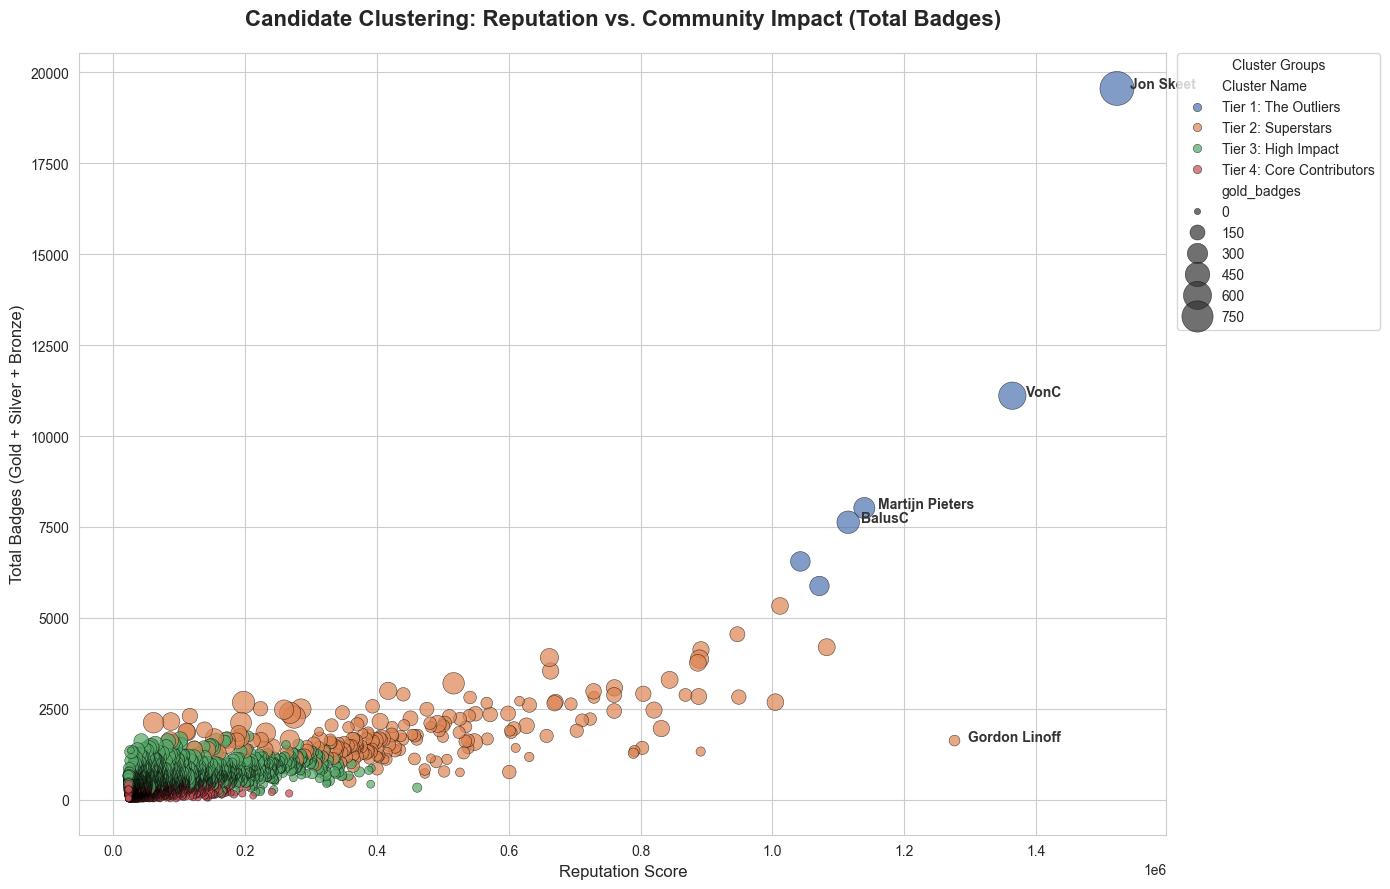

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def plot_clustering_results(file_path):
    # 1. Load Data
    try:
        df = pd.read_csv("global_candidates.csv", on_bad_lines='skip')
    except:
        df = pd.read_csv("global_candidates.csv")

    # 2. Feature Engineering
    # Combine badges for a cleaner 2D representation
    df['total_badges'] = df['gold_badges'] + df['silver_badges'] + df['bronze_badges']
    
    # We will cluster based on these three dimensions
    features = ['reputation', 'total_badges', 'gold_badges']
    df_features = df[features].fillna(0)

    # 3. Apply K-Means Clustering
    # We must scale the data first so Reputation (1.5M) doesn't drown out Gold Badges (500)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_features)

    # We use 4 clusters to find natural groupings
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(scaled_features)

    # Rename clusters for readability (based on logic, though ID assignment is random)
    # This logic sorts clusters by mean reputation to give them logical order in legend
    cluster_mapping = df.groupby('cluster')['reputation'].mean().sort_values(ascending=False).index
    rename_map = {
        cluster_mapping[0]: 'Tier 1: The Outliers',
        cluster_mapping[1]: 'Tier 2: Superstars',
        cluster_mapping[2]: 'Tier 3: High Impact',
        cluster_mapping[3]: 'Tier 4: Core Contributors'
    }
    df['Cluster Name'] = df['cluster'].map(rename_map)

    # 4. Generate Scatter Plot
    plt.figure(figsize=(14, 9))
    
    # Set style
    sns.set_style("whitegrid")
    
    # Create the scatter
    scatter = sns.scatterplot(
        data=df, 
        x='reputation', 
        y='total_badges', 
        hue='Cluster Name',      # Color by the K-Means cluster
        size='gold_badges',      # Size of dot = Number of Gold Badges
        sizes=(20, 600),         # Range of dot sizes
        palette='deep',
        alpha=0.7,
        edgecolor='black'
    )

    # 5. Annotation (Labeling the interesting data points)
    # We label the top candidates and specific outliers for context
    
    # Sort by reputation to label the top 5
    top_candidates = df.sort_values('reputation', ascending=False).head(5)
    
    # Also find Gordon Linoff specifically to show the High Rep/Lower Badge dynamic
    gordon = df[df['display_name'].str.contains('Gordon Linoff', case=False, na=False)]
    
    to_label = pd.concat([top_candidates, gordon]).drop_duplicates()

    texts = []
    for i, row in to_label.iterrows():
        plt.text(
            row['reputation'] + 20000,  # Offset x slightly
            row['total_badges'], 
            row['display_name'], 
            fontsize=10, 
            weight='bold',
            color='#333333'
        )

    # 6. Final Polish
    plt.title('Candidate Clustering: Reputation vs. Community Impact (Total Badges)', fontsize=16, weight='bold', pad=20)
    plt.xlabel('Reputation Score', fontsize=12)
    plt.ylabel('Total Badges (Gold + Silver + Bronze)', fontsize=12)
    
    # Move legend to best location
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., title="Cluster Groups")
    
    plt.tight_layout()
    plt.show()

# Run the function
if __name__ == "__main__":
    plot_clustering_results('global_candidates.csv')